# Long-slit spectroscopy in the N-band of an AGN model (input data preparation)

This notebook describes how to prepare a data cube for observation with Scopesim. The cube has been provided by Marko Stalevski and contains the simulation of an AGN. It is sampled on an irregular wavelength grid; Scopesim can deal with that but the data have to be converted to a form that Scopesim can understand. The notebook also shows how to rotate the data cube to provide interesting slit orientations.  

In [1]:
import numpy as np
from scipy.interpolate import RectBivariateSpline

from astropy.io import ascii as ioascii   # "ascii" is a python builtin, so we rename the module
from astropy.io import fits
from astropy.wcs import WCS

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

In [2]:
import scopesim as sim
sim.bug_report()

# Edit this path if you have a custom install directory, otherwise comment it out. [For ReadTheDocs only]
sim.rc.__config__["!SIM.file.local_packages_path"] = "../../../"

Python:
3.11.4 | packaged by Anaconda, Inc. | (main, Jul  5 2023, 13:38:37) [MSC v.1916 64 bit (AMD64)]

Installed Python packages:
           anisocado: 0.3.0
         astar-utils: 0.2.3a0
             astropy: 5.3.4
      beautifulsoup4: 4.12.2
            docutils: 0.19
               httpx: 0.23.3
                lxml: 4.9.4
          matplotlib: 3.8.0
      more-itertools: 10.1.0
               numpy: 1.26.3
               pooch: 1.7.0
              pyyaml: 6.0.1
               scipy: 1.11.4
            scopesim: 0.8.2
       scopesim_data: could not be loaded.
  scopesim_templates: 0.5.1
         skycalc_ipy: 0.4.0
             synphot: 1.2.1
                tqdm: 4.66.1

Installed IRDB packages:
  Armazones: 2023-07-11
        ELT: 2024-02-29
      METIS: 2024-02-29

Operating System info:
   System: Windows
  Release: 10
  Version: 10.0.22631
  Machine: AMD64


## Preparing the data cube for Scopesim

The data used in this notebook have to be downloaded from the Scopesim server. If you already have them, make sure that the files are in the current working directory; you can then skip the download step.

The data come in two files: a FITS file that contains the data cube and a text file that contains amongst other things the wavelength vector on which the cube has been sampled. The wavelength vector has to be appended to the FITS file as a binary table extension following the prescription of Greisen et al. (2006, A&A 446, 747). 

In [3]:
fitsfile = "tor_oa20_t9-5sg_Rout1.5_Rin0.13_p0__hypSh_oa40-50_tV-0.01g_D40_a0.2-0.4_tlt0_i90_total.fits"
sedfile = "tor_oa20_t9-5sg_Rout1.5_Rin0.13_p0__hypSh_oa40-50_tV-0.01g_D40_a0.2-0.4_tlt0_i90_sed.dat"

sim.download_example_data([fitsfile, sedfile])

[WindowsPath('C:/Users/ghost/Desktop/PhD/irdb/METIS/docs/example_notebooks/tor_oa20_t9-5sg_Rout1.5_Rin0.13_p0__hypSh_oa40-50_tV-0.01g_D40_a0.2-0.4_tlt0_i90_total.fits'),
 WindowsPath('C:/Users/ghost/Desktop/PhD/irdb/METIS/docs/example_notebooks/tor_oa20_t9-5sg_Rout1.5_Rin0.13_p0__hypSh_oa40-50_tV-0.01g_D40_a0.2-0.4_tlt0_i90_sed.dat')]

In [4]:
wave = np.array(ioascii.read(sedfile)['col1'])
nwave = wave.shape[0]

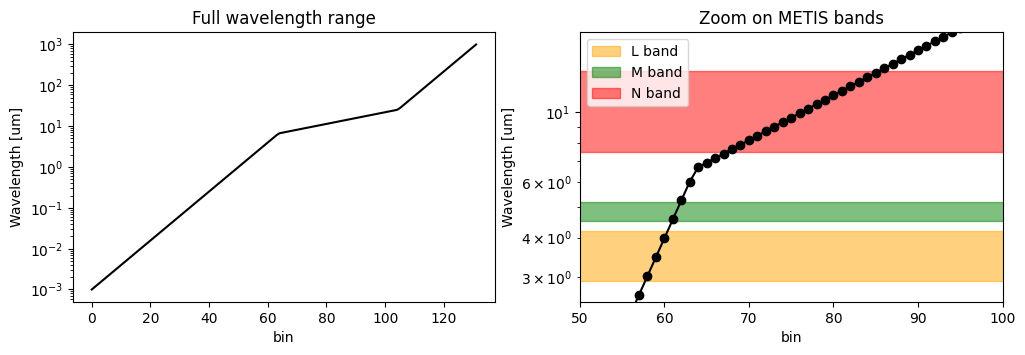

In [5]:
plt.figure(figsize=(12, 3.5))
plt.subplot(121)
plt.plot(wave, 'k-')
plt.xlabel("bin")
plt.ylabel("Wavelength [um]")
plt.title("Full wavelength range")
plt.semilogy();

plt.subplot(122)
plt.plot(wave, 'ko-')
plt.xlabel("bin")
plt.ylabel("Wavelength [um]")
plt.fill_between([0, nwave], 2.9, 4.2, color='orange', label="L band", alpha=0.5)
plt.fill_between([0, nwave], 4.5, 5.2, color='green', label="M band", alpha=0.5)
plt.fill_between([0, nwave], 7.5, 13.5, color='red', label="N band", alpha=0.5)
plt.xlim(50, 100)
plt.ylim(2.5, 18)
plt.semilogy()
plt.title("Zoom on METIS bands")
plt.legend();

It can be seen that wavelengths are on logarithmic grids with a higher sampling rate across the N band. It would be possible to extract the just that part of the cube that covers the N band and construct a standard WCS of type `CTYPE3 = 'WAVE-LOG'` for that. We can also use the entire cube and construct a tabular WCS (`CTYPE3 = 'WAVE-TAB'`).

## Tabular WCS

In [6]:
hdulist = fits.open(fitsfile)
hdulist[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  600 / length of data axis 1                          
NAXIS2  =                  600 / length of data axis 2                          
NAXIS3  =                  132 / length of data axis 3                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BSCALE  =                   1.                                                  
BZERO   =                   0.                                                  
DATE    = '2017-03-15T07:53:03' / Date and time of creation (UTC)               
ORIGIN  = 'SKIRT simulation'

The cube actually contains $\lambda f_\lambda$ in units of W/m2/arcsec2. Scopesim works on $f_\lambda$, so we have to divide the cube data by wavelength. This changes the units to W/m2/um/arcsec2: 

In [7]:
hdulist[0].data /= wave[:, None, None]      # broadcast wavelength vector to pseudo-3D structure
hdulist[0].header['BUNIT'] = 'W/m2/um/arcsec2'

We create the wavelength lookup table following Greisen et al. (2006). The binary table has a single column, which we call "WAVELENGTH", with a single row that contains the wavelength array of length `nwave`. The binary table HDU is called "WCS-TAB" and is appended to the HDU list.

In [8]:
wavecol = fits.Column(name="WAVELENGTH", array=np.array([wave]),
                     format=f"{nwave}E", unit="um")
wave_hdu = fits.BinTableHDU.from_columns([wavecol], name="WCS-TAB")
hdulist.append(wave_hdu)

The third dimension of the WCS needs to be declared in the cube hdu as type `WAVE-TAB`. The keywords `PS3_0` and `PS3_1` point to the table extension and the column in the table, respectively.  

In [9]:
hdulist[0].header["CTYPE3"] = "WAVE-TAB", "Coordinate type"
hdulist[0].header["CUNIT3"] = "um", "Coordinate units"
hdulist[0].header["PS3_0"] = "WCS-TAB", "Coord table extension name"
hdulist[0].header["PS3_1"] = "WAVELENGTH", "Coord table column name"

The spatial WCS as it appears in the original file is not useful. In fact the `CDELT` values are given in units of parsec, whereas Scopesim expects angular units. The model represents the Circinus galaxy, which is at a distance of 4.2 Mpc, which results in a scale of 0.049 pc/arcsec. For simplicity, the type of the WCS is declared as 'LINEAR', thus neglecting the nonlinear part of the more common projections. 

In [10]:
hdulist[0].header['CTYPE1'] = 'LINEAR'
hdulist[0].header['CTYPE2'] = 'LINEAR'
hdulist[0].header['CDELT1'] *= 0.049
hdulist[0].header['CDELT2'] *= 0.049
hdulist[0].header['CUNIT1'] = 'arcsec'
hdulist[0].header['CUNIT2'] = 'arcsec'

In [11]:
hdulist.writeto("AGN_sim_prepared.fits", overwrite=True)

## Visual inspection of the cube
We first look at a plane of cube somewhere in the N-band, then produce a through-slit image in the N2-band using the widest slit available in METIS.

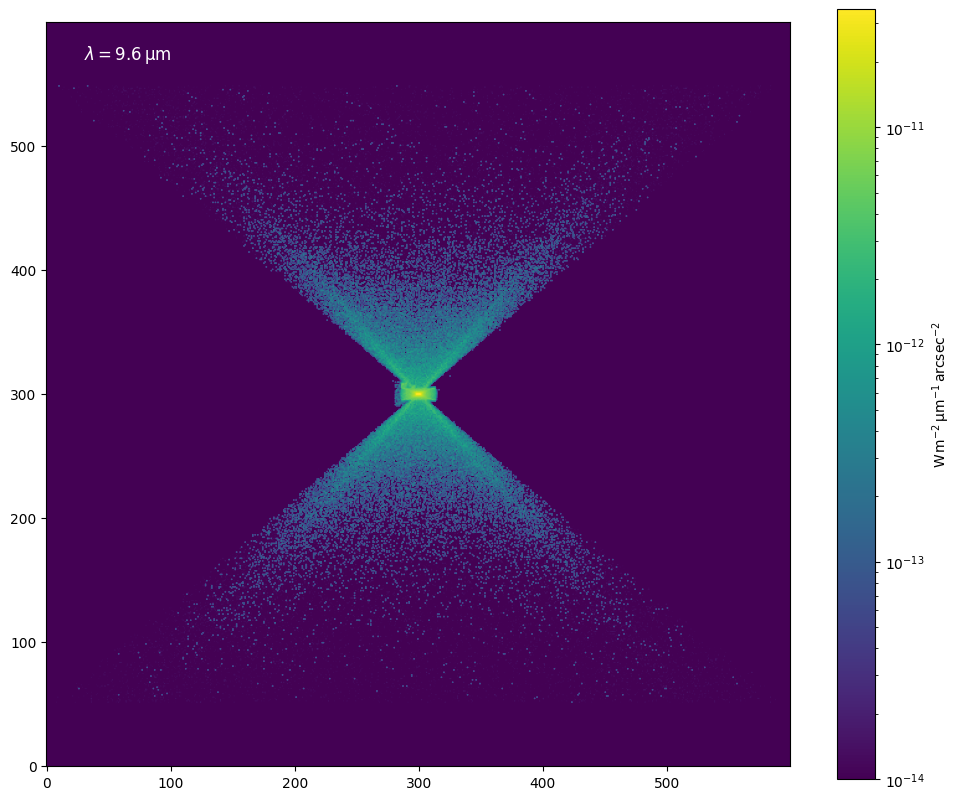

In [12]:
plt.figure(figsize=(12, 10))
plt.imshow(hdulist[0].data[75,] + 1e-14, origin='lower', norm=LogNorm())  # 1e-14 added to avoid zeros in LogNorm
plt.colorbar(label=r"$\mathrm{W\,m^{-2}\,\mu m^{-1}\,arcsec^{-2}}$")
plt.text(30, 570, r"$\lambda = {:.2}\,\mathrm{{\mu m}}$".format(wave[75]), color='white', size='large');

In [13]:
src = sim.Source(cube="AGN_sim_prepared.fits")

In [14]:
cmd = sim.UserCommands(use_instrument="METIS", set_modes=["img_n"], 
                      properties={"!OBS.slit": "E-114_2"})
metis = sim.OpticalTrain(cmd)

metis.observe(src)

 FOVs:   0%|                                                                                     | 0/3 [00:00<?, ?it/s]

astar.scopesim.optics.image_plane_utils - WARNING: imagehdu.data.ndim is 2, but primary_wcs.naxis with key   is 3, both should be equal.
astar.scopesim.optics.image_plane_utils - WARNING: imagehdu.data.ndim is 2, but wcs.naxis with key   is 3, both should be equal.



 FOV effects:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

astar.scopesim.effects.psf_utils - WARNING: PSF center off



 FOVs:  33%|█████████████████████████▋                                                   | 1/3 [00:00<00:00,  6.22it/s]

astar.scopesim.optics.image_plane_utils - WARNING: imagehdu.data.ndim is 2, but primary_wcs.naxis with key   is 3, both should be equal.
astar.scopesim.optics.image_plane_utils - WARNING: imagehdu.data.ndim is 2, but wcs.naxis with key   is 3, both should be equal.



 FOV effects:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

astar.scopesim.effects.psf_utils - WARNING: PSF center off



 FOVs:  67%|███████████████████████████████████████████████████▎                         | 2/3 [00:00<00:00,  4.47it/s]

astar.scopesim.optics.image_plane_utils - WARNING: imagehdu.data.ndim is 2, but primary_wcs.naxis with key   is 3, both should be equal.
astar.scopesim.optics.image_plane_utils - WARNING: imagehdu.data.ndim is 2, but wcs.naxis with key   is 3, both should be equal.



 FOV effects:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

astar.scopesim.effects.psf_utils - WARNING: PSF center off



 FOVs: 100%|█████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]
 Image Plane effects: 0it [00:00, ?it/s]


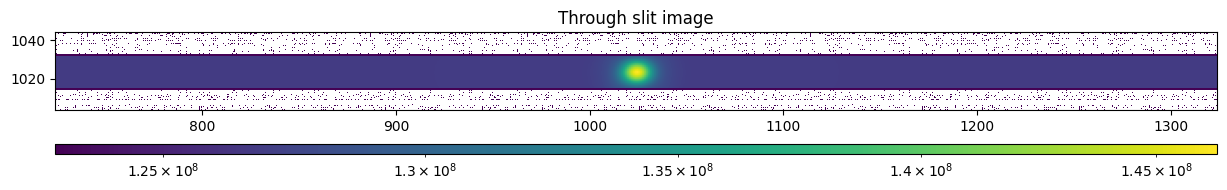

In [15]:
plt.figure(figsize=(15, 3))
plt.imshow(metis.image_planes[0].data[1004:1044, 724:1324], norm=LogNorm(vmin=1.23e8),
          extent=(724, 1324, 1004, 1044))
metis.image_planes[0].data[1024, 500]
plt.colorbar(location='bottom', aspect=120)
plt.title("Through slit image");

## Rotating the field
The METIS slit is always aligned with the x-axis. For more interesting slit orientations, we actually have to rotate the input cube. We pick an angle of 50 degrees (counterclockwise from the positive x-direction).

In [16]:
angle = 50 * np.pi / 180    # convert from degrees to radians

We need two WCSs: `wcs_orig` is the WCS of the original image, `wcs_rot` will be modified to represent the rotated image. To that end, we define the rotation matrix (`PCi_j`) and keep the pixel scales in `CDELTi`.

In [17]:
wcs_orig = WCS("AGN_sim_prepared.fits").sub(2)
wcs_rot = WCS("AGN_sim_prepared.fits").sub(2)

In [18]:
wcs_rot.wcs.pc = [[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]

Now define the interpolation function on the original image in terms of world coordinates at the pixel positions. 

In [19]:
i_orig = np.arange(hdulist[0].header['NAXIS1'])
j_orig = np.arange(hdulist[0].header['NAXIS2'])
x_orig, y_orig = wcs_orig.all_pix2world(i_orig, j_orig, 0) 

In [20]:
interp = RectBivariateSpline(y_orig, x_orig, hdulist[0].data[75,], kx=1, ky=1)

On the rotated image, world coordinates (x,y) are not aligned with pixel coordinates (i,j), and we need to work with 2D images rather than 1D vectors. We keep the size of the original image.

In [21]:
i_rot, j_rot = np.meshgrid(i_orig, j_orig)

In [22]:
x_rot, y_rot = wcs_rot.all_pix2world(i_rot, j_rot, 0)

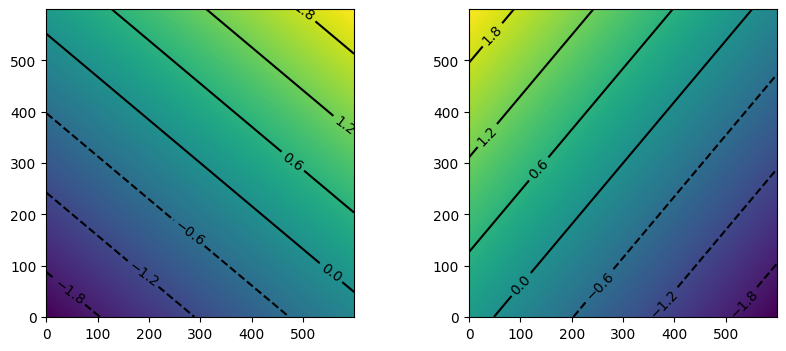

In [23]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(x_rot, origin='lower')
cs = plt.contour(x_rot, origin='lower', colors='k')
plt.clabel(cs)
plt.subplot(122)
plt.imshow(y_rot, origin='lower')
cs = plt.contour(y_rot, origin='lower', colors='k')
plt.clabel(cs);

In [24]:
imgrot = interp(y_rot, x_rot, grid=False)

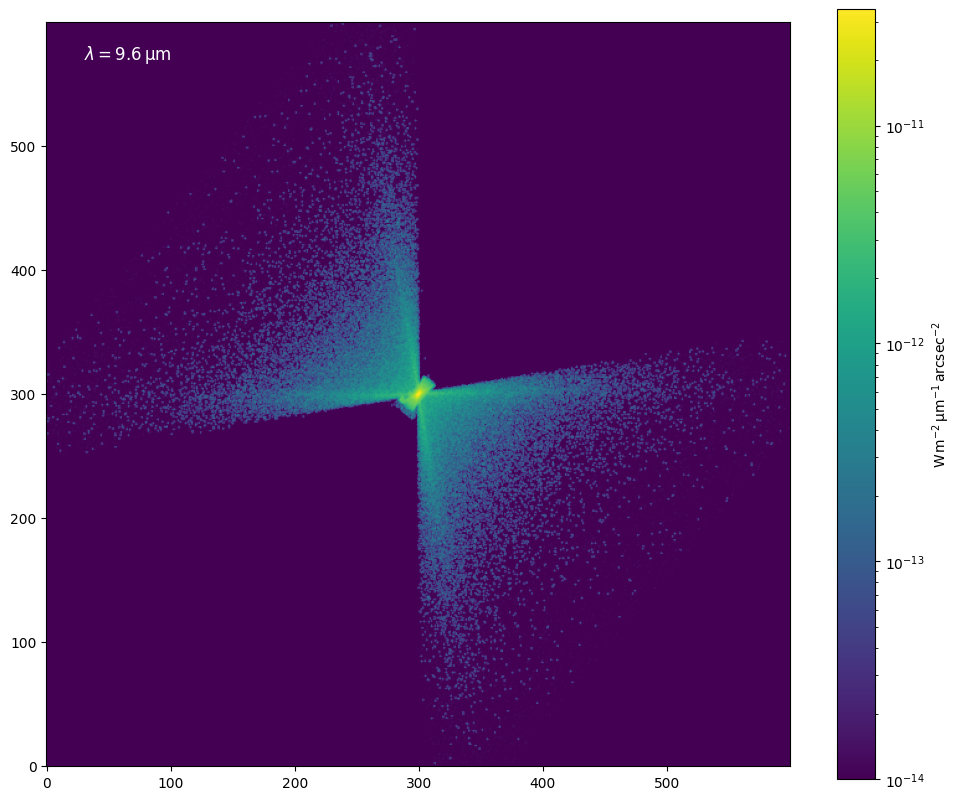

In [25]:
plt.figure(figsize=(12, 10))
plt.imshow(imgrot + 1e-14, origin='lower', norm=LogNorm())    # 1e-14 added to avoid zeros in LogNorm
plt.colorbar(label=r"$\mathrm{W\,m^{-2}\,\mu m^{-1}\,arcsec^{-2}}$")
plt.text(30, 570, r"$\lambda = {:.2}\,\mathrm{{\mu m}}$".format(wave[75]), color='white', size='large');

Apply the procedure to the entire cube:

In [26]:
for iplane, plane in enumerate(hdulist[0].data):
    interp = RectBivariateSpline(y_orig, x_orig, plane, kx=1, ky=1)
    hdulist[0].data[iplane,] = interp(y_rot, x_rot, grid=False)

In [27]:
hdulist.writeto("AGN_sim_rotated_50.fits", overwrite=True)

From this file, we can set up a new `Source` object and simulate the through-slit image.

In [28]:
src50 = sim.Source(cube="AGN_sim_rotated_50.fits")

In [29]:
metis.observe(src50, update=True)

 FOVs:   0%|                                                                                     | 0/3 [00:00<?, ?it/s]

astar.scopesim.optics.image_plane_utils - WARNING: imagehdu.data.ndim is 2, but primary_wcs.naxis with key   is 3, both should be equal.
astar.scopesim.optics.image_plane_utils - WARNING: imagehdu.data.ndim is 2, but wcs.naxis with key   is 3, both should be equal.



 FOV effects:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

astar.scopesim.effects.psf_utils - WARNING: PSF center off



 FOVs:  33%|█████████████████████████▋                                                   | 1/3 [00:00<00:00,  5.38it/s]

astar.scopesim.optics.image_plane_utils - WARNING: imagehdu.data.ndim is 2, but primary_wcs.naxis with key   is 3, both should be equal.
astar.scopesim.optics.image_plane_utils - WARNING: imagehdu.data.ndim is 2, but wcs.naxis with key   is 3, both should be equal.



 FOV effects:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

astar.scopesim.effects.psf_utils - WARNING: PSF center off



 FOVs:  67%|███████████████████████████████████████████████████▎                         | 2/3 [00:00<00:00,  4.24it/s]

astar.scopesim.optics.image_plane_utils - WARNING: imagehdu.data.ndim is 2, but primary_wcs.naxis with key   is 3, both should be equal.
astar.scopesim.optics.image_plane_utils - WARNING: imagehdu.data.ndim is 2, but wcs.naxis with key   is 3, both should be equal.



 FOV effects:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

astar.scopesim.effects.psf_utils - WARNING: PSF center off



 FOVs: 100%|█████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.94it/s]
 Image Plane effects: 0it [00:00, ?it/s]


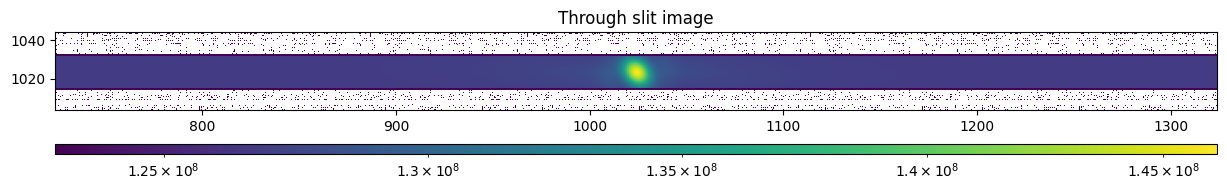

In [30]:
plt.figure(figsize=(15, 3))
plt.imshow(metis.image_planes[0].data[1004:1044, 724:1324], norm=LogNorm(vmin=1.23e8),
          extent=(724, 1324, 1004, 1044))
metis.image_planes[0].data[1024, 500]
plt.colorbar(location='bottom', aspect=120)
plt.title("Through slit image");

The spectroscopic simulation of these sources will be done in a separate notebook, `LSS_AGN-02_simulation.ipynb`.